In [1]:
import torch 
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import pandas as pd
import cv2
import os
from tqdm import tqdm

In [2]:
classes = os.listdir("/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES")

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
full_dir = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"

In [4]:
class SkinDataset(Dataset):
    def __init__(self, root, feature_extractor, labels, apply_hist_eq=False):
        self.feature_extractor = feature_extractor
        self.labels = labels
        self.files = []
        self.apply_hist_eq = apply_hist_eq

        subdirs = sorted(os.listdir(root))
        for subdir in subdirs:
            for path, _, files in os.walk(os.path.join(root, subdir)):
                for file in files:
                    self.files.append((os.path.join(root, subdir, file), subdir))

    def apply_histogram_equalization(self, img):
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        img_yuv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])

        img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

        return Image.fromarray(img_eq)

    def __getitem__(self, idx):
        image, label = self.files[idx % len(self.files)]
        img = Image.open(image).convert("RGB")
        
        if self.apply_hist_eq:
            img = self.apply_histogram_equalization(img)
        
        inputs = self.feature_extractor(images=img, return_tensors="pt")
        inputs["labels"] = torch.tensor(self.labels.index(label))
        return inputs

    def __len__(self):
        return len(self.files)

In [7]:
full_dataset = SkinDataset(full_dir, feature_extractor, classes,apply_hist_eq=True)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [8]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_epochs = 20
lr = 3e-5
eval_steps = 100
record_steps= 10
save_checkpoint = 5


model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=len(classes),
                                                   id2label={str(i): c for i, c in enumerate(classes)},
                                                   label2id={c: str(i) for i, c in enumerate(classes)},
                                                   ignore_mismatched_sizes=True).to(device)

optim = torch.optim.AdamW(model.parameters(), lr=lr)

training_stats_step = 10

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from tqdm import tqdm
from functools import partial

In [11]:
def evaluate(model, eval_loader, eval_dataset):
    correct = 0
    eval_loss = []
    
    model.eval()
    for batch in tqdm(eval_loader):
        batch_images = batch["pixel_values"].squeeze(1).to(device)
        batch_labels = batch["labels"].to(device)
        
        with torch.no_grad():
            outputs = model(pixel_values=batch_images, labels=batch_labels)
            loss = outputs[0]
            eval_loss.append(loss.item())
            correct += (torch.argmax(outputs["logits"], dim=1) == batch_labels).sum().item()
    
    accuracy = (100 * correct / len(eval_dataset))
    avg_loss = (sum(eval_loss) / len(epoch_loss))
    
    return accuracy, avg_loss

In [12]:
tqdm = partial(tqdm, position=0, leave=True)

In [13]:
for epoch in range(1, num_epochs + 1):
    epoch_loss = []
    epoch_acc = []

    print(f"Epoch {epoch}")
    for index, batch in enumerate(tqdm(train_loader)):
        model.train()
        optim.zero_grad()

        batch_images = batch["pixel_values"].squeeze(1).to(device)
        batch_labels = batch["labels"].to(device)
        size = len(batch_images)

        outputs = model(pixel_values=batch_images, labels=batch_labels)

        loss = outputs[0]
        epoch_loss.append(loss.item())
        loss.backward()
        optim.step()

        correct = (torch.argmax(outputs["logits"], dim=1) == batch_labels).sum().item()
        acc = (100 * correct) / size
        epoch_acc.append(acc)

    avg_accuracy = sum(epoch_acc) / len(epoch_acc)
    avg_loss = sum(epoch_loss) / len(epoch_loss)

    if epoch % save_checkpoint == 0:
        torch.save(model.state_dict(), f"model_epoch_{epoch}.pt")

    val_acc, val_loss = evaluate(model, test_loader, test_dataset)

    print("Evaluating on validation set")
    print(f"Validation loss: {round(val_loss, 4)}, Validation accuracy: {round(val_acc, 4)}%")
    print(f"Epoch: {epoch}  Avg loss: {round(avg_loss, 4)}  Avg accuracy: {round(avg_accuracy, 4)}%")

Epoch 1


100%|██████████| 170/170 [02:57<00:00,  1.05s/it]


Evaluating on validation set
Validation loss: 0.1457, Validation accuracy: 78.2545%
Epoch: 1  Avg loss: 0.7629  Avg accuracy: 71.7514%
Epoch 2


100%|██████████| 170/170 [02:04<00:00,  1.37it/s]


Evaluating on validation set
Validation loss: 0.1166, Validation accuracy: 82.6735%
Epoch: 2  Avg loss: 0.3988  Avg accuracy: 86.0149%
Epoch 3


100%|██████████| 170/170 [02:06<00:00,  1.34it/s]


Evaluating on validation set
Validation loss: 0.1175, Validation accuracy: 84.1282%
Epoch: 3  Avg loss: 0.1819  Avg accuracy: 94.4956%
Epoch 4


100%|██████████| 170/170 [02:04<00:00,  1.37it/s]


Evaluating on validation set
Validation loss: 0.1224, Validation accuracy: 85.638%
Epoch: 4  Avg loss: 0.0739  Avg accuracy: 98.0532%
Epoch 5


100%|██████████| 170/170 [02:06<00:00,  1.35it/s]


Evaluating on validation set
Validation loss: 0.1317, Validation accuracy: 85.012%
Epoch: 5  Avg loss: 0.0461  Avg accuracy: 98.6883%
Epoch 6


100%|██████████| 170/170 [02:04<00:00,  1.37it/s]


Evaluating on validation set
Validation loss: 0.1927, Validation accuracy: 78.678%
Epoch: 6  Avg loss: 0.0307  Avg accuracy: 99.0657%
Epoch 7


100%|██████████| 170/170 [02:24<00:00,  1.17it/s]


Evaluating on validation set
Validation loss: 0.1446, Validation accuracy: 84.3307%
Epoch: 7  Avg loss: 0.0549  Avg accuracy: 98.1499%
Epoch 8


100%|██████████| 170/170 [03:10<00:00,  1.12s/it]


Evaluating on validation set
Validation loss: 0.1512, Validation accuracy: 84.791%
Epoch: 8  Avg loss: 0.0336  Avg accuracy: 98.8172%
Epoch 9


100%|██████████| 170/170 [03:00<00:00,  1.06s/it]


Evaluating on validation set
Validation loss: 0.1717, Validation accuracy: 83.852%
Epoch: 9  Avg loss: 0.0241  Avg accuracy: 99.1163%
Epoch 10


100%|██████████| 170/170 [02:06<00:00,  1.34it/s]


Evaluating on validation set
Validation loss: 0.1768, Validation accuracy: 83.7967%
Epoch: 10  Avg loss: 0.039  Avg accuracy: 98.6239%
Epoch 11


100%|██████████| 170/170 [02:11<00:00,  1.29it/s]


Evaluating on validation set
Validation loss: 0.1638, Validation accuracy: 84.7542%
Epoch: 11  Avg loss: 0.0233  Avg accuracy: 99.1199%
Epoch 12


100%|██████████| 170/170 [02:03<00:00,  1.38it/s]


Evaluating on validation set
Validation loss: 0.1649, Validation accuracy: 85.2513%
Epoch: 12  Avg loss: 0.0295  Avg accuracy: 98.8391%
Epoch 13


100%|██████████| 170/170 [02:20<00:00,  1.21it/s]


Evaluating on validation set
Validation loss: 0.1646, Validation accuracy: 84.9015%
Epoch: 13  Avg loss: 0.024  Avg accuracy: 99.0473%
Epoch 14


  0%|          | 3/679 [00:03<14:07,  1.25s/it]


KeyboardInterrupt: 

In [33]:
import requests
from io import BytesIO
import torch.nn.functional as F  

def predict_skin_disease_with_external(model, image_url, feature_extractor, threshold=0.8):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].squeeze(1).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        
        probs = F.softmax(logits, dim=1)
        max_prob, pred_class = torch.max(probs, dim=1)

        predicted_label = model.config.id2label[str(pred_class.item())]
        probability = max_prob.item()

        if probability < threshold:
            return "Normal Skin", probability
        else:
            return predicted_label, probability

external_image_url = "https://previews.123rf.com/images/mraoraor/mraoraor1806/mraoraor180600007/104837305-closeup-back-of-man-on-white-background-beauty-healthy-skin-care-concept.jpg"
predicted_label, probability = predict_skin_disease_with_external(model, external_image_url, feature_extractor)

print(f"Predicted label: {predicted_label}, Probability: {round(probability * 100, 2)}%")


Predicted label: Normal Skin, Probability: 75.86%


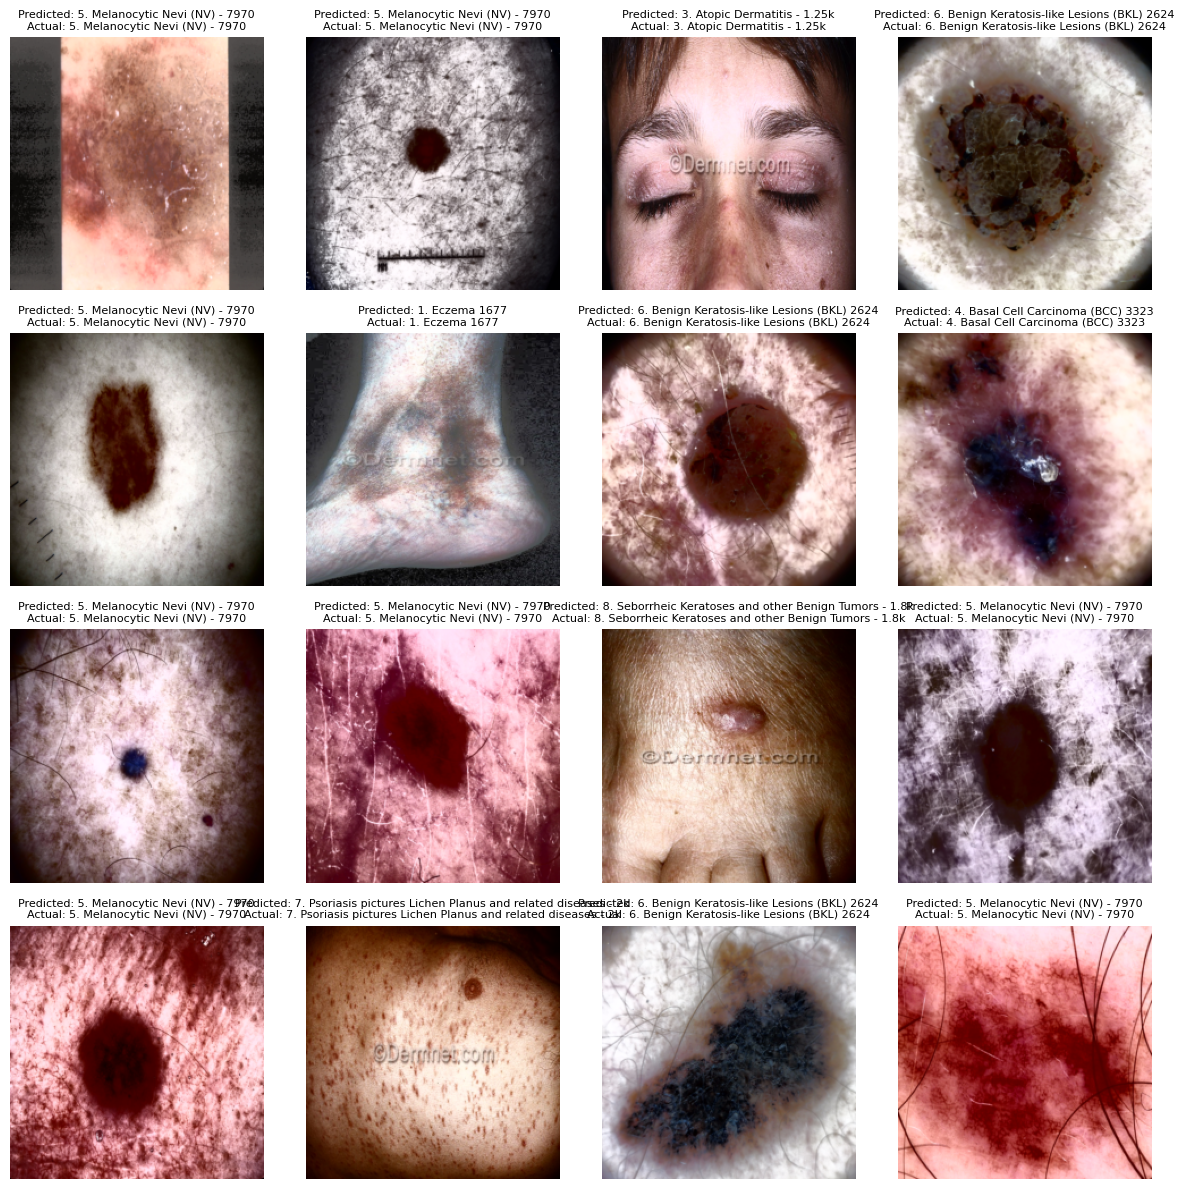

In [34]:
plt.figure(figsize=(12, 12))

for batch in test_loader:
    images = batch['pixel_values'].squeeze(1).to(device)
    true_labels = batch['labels'].to(device)
    
    with torch.no_grad():
        outputs = model(pixel_values=images)
        predictions = torch.argmax(outputs.logits, dim=1)

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        
        img_np = images[i].cpu().numpy().transpose(1, 2, 0)
        
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        plt.imshow(img_np)
        
        # Get the predicted and actual labels
        pred_label = model.config.id2label[str(predictions[i].item())]
        actual_label = model.config.id2label[str(true_labels[i].item())]
        
        plt.title(f"Predicted: {pred_label}\nActual: {actual_label}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    break